In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_samples
)
plt.style.use("seaborn-v0_8-whitegrid")

sns.set_context("talk")
sns.set_palette("deep")

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [77]:
# Load PCA transformed data (4 components)
X_pca = pd.read_csv("pca_transformed_data.csv")

print("Shape:", X_pca.shape)
X_pca.head()

Shape: (52585, 4)


,PC1,PC2,PC3,PC4
0,1.487263,-0.178599,-0.413503,0.712809
1,-0.791526,-0.103729,-0.462934,1.195262
2,0.972376,-1.780369,0.694588,0.930401
3,1.180382,-1.284150,0.685697,0.896481
4,-1.434799,0.303782,-1.078600,-0.882710


In [78]:
kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=20
)

cluster_labels = kmeans.fit_predict(X_pca)

X_pca['Cluster'] = cluster_labels

print("Cluster counts:")
print(X_pca['Cluster'].value_counts())

Cluster counts:
Cluster
0    28824
3    10197
1     6964
2     6600
Name: count, dtype: int64


In [79]:
original_df = pd.read_csv("final_feature_engineered.csv")

# attach cluster labels
original_df['Cluster'] = cluster_labels

print(original_df.shape)

cluster_names = {
    0: "Low Cost Sustainable Segment",
    1: "Climate Sensitive Segment",
    2: "Operational Optimization Opportunity",
    3: "High HVAC High Renewable Segment"
}

original_df['Cluster_Name'] = original_df['Cluster'].map(cluster_names)

(52585, 66)


In [80]:
X_features = X_pca.drop(columns=['Cluster'])

sil_score = silhouette_score(X_features, cluster_labels)
ch_score = calinski_harabasz_score(X_features, cluster_labels)
db_score = davies_bouldin_score(X_features, cluster_labels)

print("Silhouette:", round(sil_score,4))
print("Calinski-Harabasz:", round(ch_score,2))
print("Davies-Bouldin:", round(db_score,4))

Silhouette: 0.2521
Calinski-Harabasz: 15353.73
Davies-Bouldin: 1.3044


In [81]:
# ==============================
# Stability Test
# ==============================

stability_scores = []

for seed in range(10):
    km = KMeans(n_clusters=4, random_state=seed, n_init=20)
    labels_temp = km.fit_predict(X_features)
    score = silhouette_score(X_features, labels_temp)
    stability_scores.append(score)

print("Mean Silhouette:", np.mean(stability_scores))
print("Std Deviation:", np.std(stability_scores))

Mean Silhouette: 0.25213524489405736
Std Deviation: 0.0004752035496091478


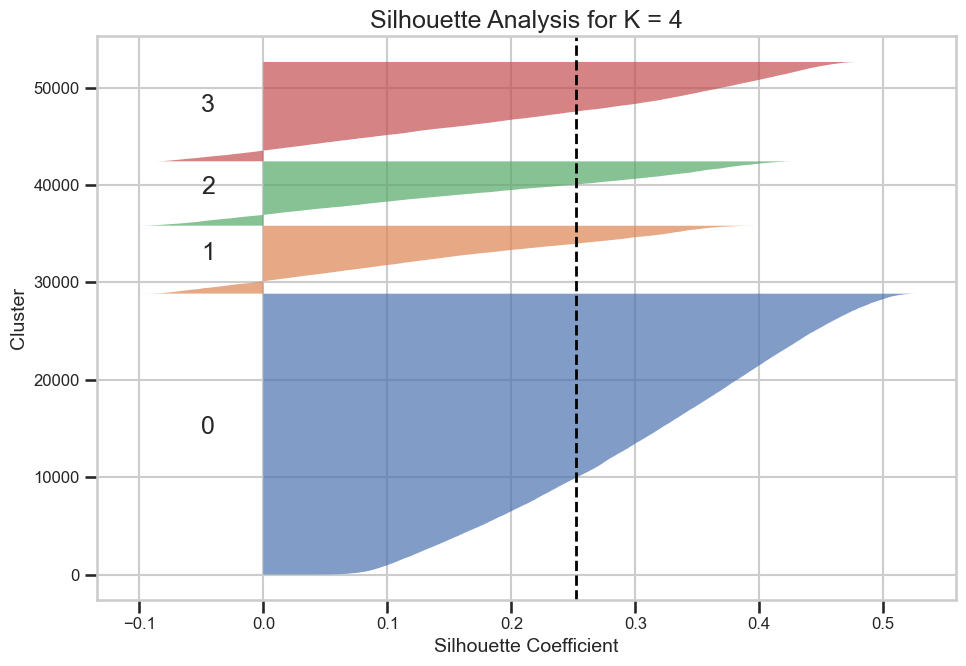

In [82]:
sample_sil_values = silhouette_samples(X_features, cluster_labels)

fig, ax = plt.subplots(figsize=(10,7))

y_lower = 10

for i in range(4):
    cluster_sil_values = sample_sil_values[cluster_labels == i]
    cluster_sil_values.sort()
    size_cluster_i = cluster_sil_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_sil_values,
        alpha=0.7
    )

    ax.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.axvline(x=sil_score, color="black", linestyle="--", linewidth=2)

ax.set_title("Silhouette Analysis for K = 4")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")

plt.tight_layout()
plt.show()

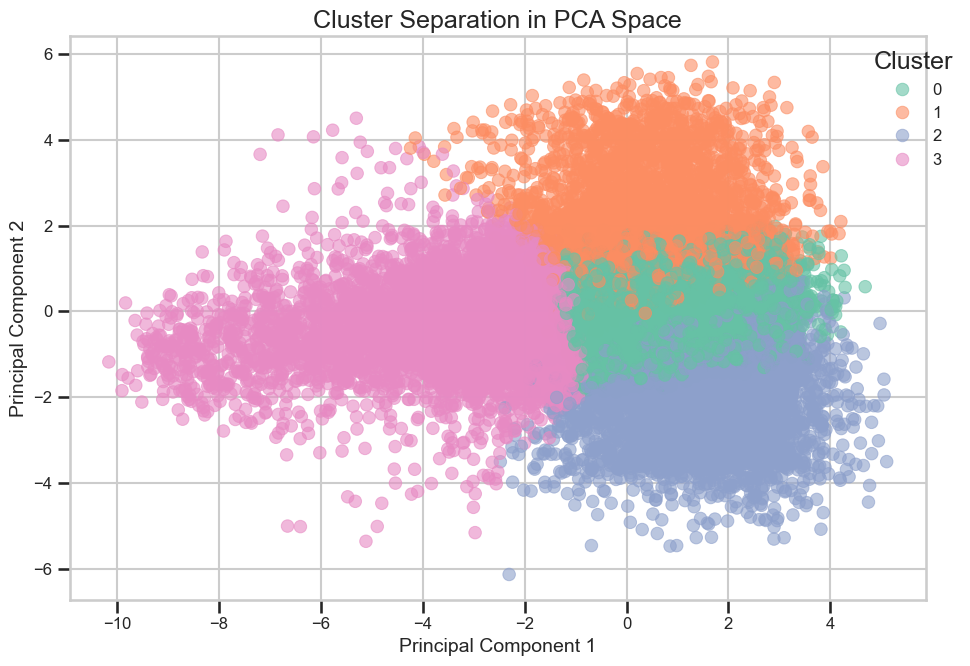

In [83]:
plt.figure(figsize=(10,7))

sns.scatterplot(
    data=X_pca,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="Set2",
    alpha=0.6,
    edgecolor=None
)

plt.title("Cluster Separation in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05,1))
plt.tight_layout()
plt.show()

C:\Users\lavde\AppData\Local\Temp\ipykernel_28204\1762882875.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


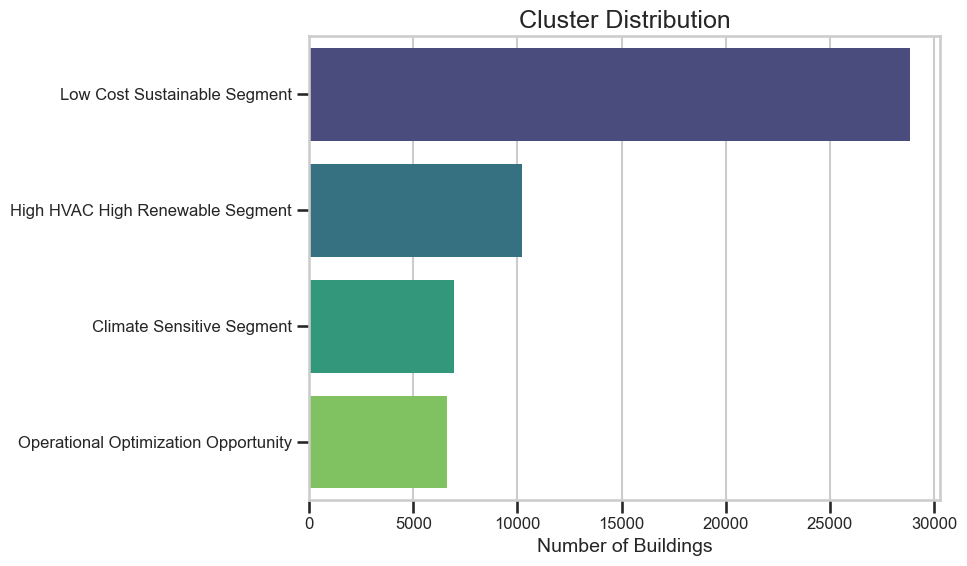

In [84]:
cluster_counts = original_df['Cluster_Name'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(
    x=cluster_counts.values,
    y=cluster_counts.index,
    palette="viridis"
)

plt.title("Cluster Distribution")
plt.xlabel("Number of Buildings")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [85]:
centroid_features = [
    'Energy_Intensity',
    'HVAC_Ratio',
    'Lighting_Ratio',
    'Occupancy_Adjusted_Energy',
    'Renewable_Ratio',
    'Carbon_Load',
    'Efficiency_Gap',
    'Savings_Gap',
    'Grid_Stress',
    'Temp_Deviation'
]

cluster_centroids = original_df.groupby('Cluster')[centroid_features].mean()
cluster_centroids

,Energy_Intensity,HVAC_Ratio,Lighting_Ratio,Occupancy_Adjusted_Energy,Renewable_Ratio,Carbon_Load,Efficiency_Gap,Savings_Gap,Grid_Stress,Temp_Deviation
Cluster,,,,,,,,,,
0,0.076372,0.280058,0.199181,0.523188,0.091279,10.119699,27.426609,4.969603,0.775286,6.833455
1,0.067524,0.244449,0.218876,0.514194,0.103933,9.968825,27.608650,4.901383,0.700904,19.601097
2,0.075931,0.290765,0.130728,0.876289,0.099633,10.035874,27.869311,4.965635,0.759375,8.444813
3,0.034097,0.711501,0.493883,0.337741,0.246117,9.145030,27.794831,5.058260,0.356272,8.184595


In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_centroids),
    columns=cluster_centroids.columns,
    index=cluster_centroids.index
)

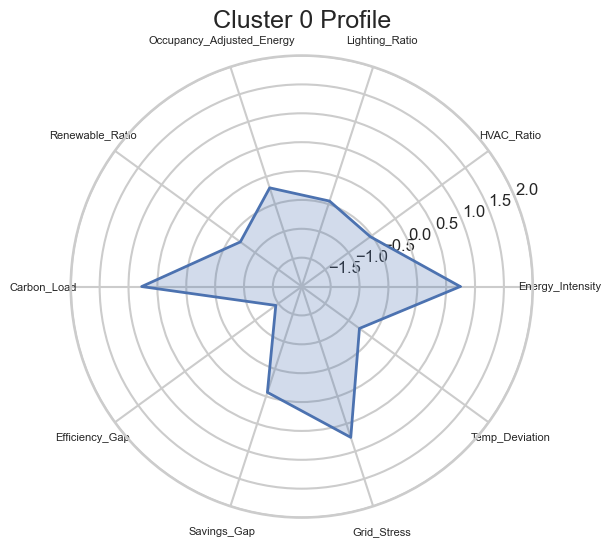

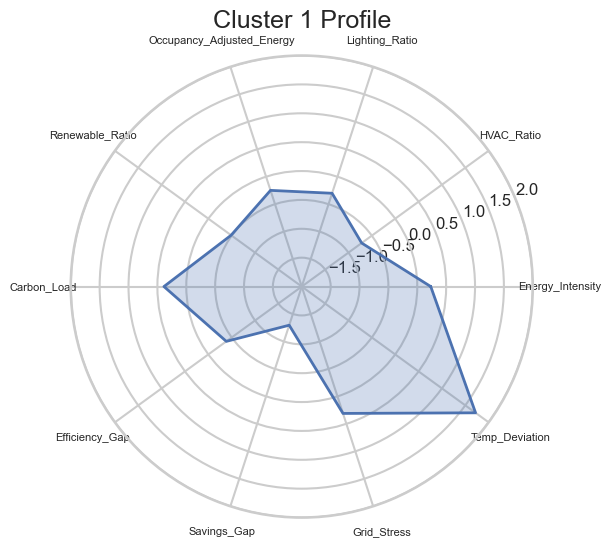

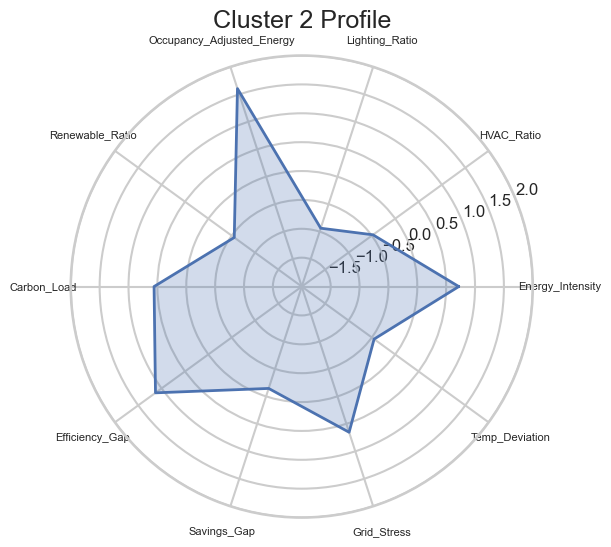

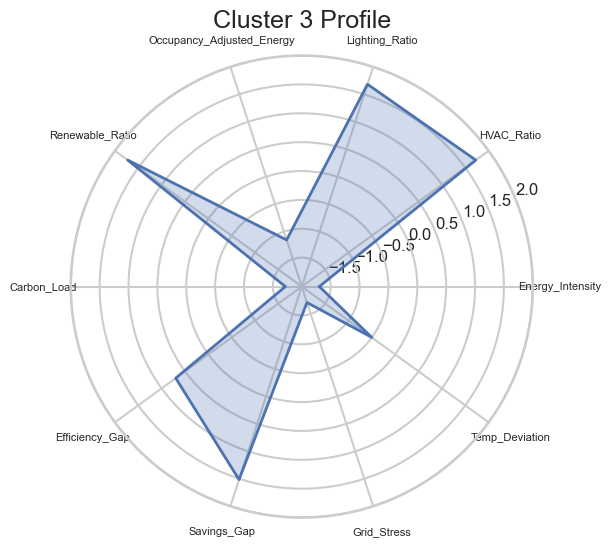

In [87]:
def plot_radar(cluster_id):
    values = cluster_means_scaled.loc[cluster_id].values
    labels = cluster_means_scaled.columns

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)
    ax.set_ylim(-2, 2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=8)
    ax.set_title(f"Cluster {cluster_id} Profile",pad =20)
    plt.show()

for c in cluster_means_scaled.index:
    plot_radar(c)

ANOVA

In [88]:
from scipy.stats import f_oneway

anova_results = {}

for feature in centroid_features:
    groups = [
        original_df[original_df['Cluster'] == c][feature]
        for c in original_df['Cluster'].unique()
    ]
    
    f_stat, p_value = f_oneway(*groups)
    
    anova_results[feature] = {
        'F-statistic': f_stat,
        'p-value': p_value
    }

anova_df = pd.DataFrame(anova_results).T
anova_df

,F-statistic,p-value
Energy_Intensity,347.442723,1.916862e-223
HVAC_Ratio,8219.653637,0.000000e+00
Lighting_Ratio,8418.613937,0.000000e+00
Occupancy_Adjusted_Energy,15155.890870,0.000000e+00
Renewable_Ratio,6416.681594,0.000000e+00
Carbon_Load,9601.115335,0.000000e+00
Efficiency_Gap,1.656283,1.741063e-01
Savings_Gap,0.716985,5.416776e-01
Grid_Stress,10616.293665,0.000000e+00
Temp_Deviation,10817.178928,0.000000e+00


Energy impact cost analysis

C:\Users\lavde\AppData\Local\Temp\ipykernel_28204\1920415580.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


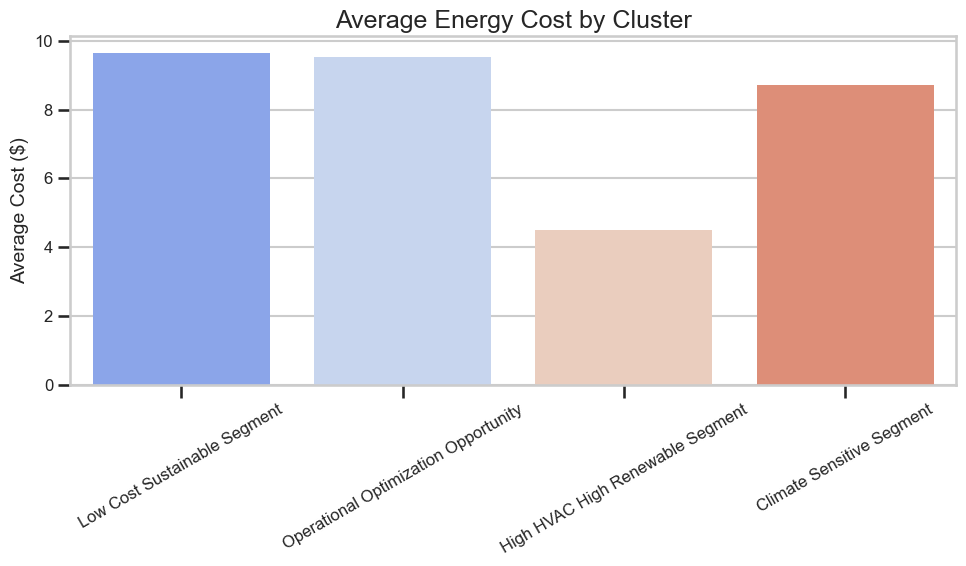

In [89]:
original_df['Energy_Cost'] = (
    original_df['Energy Consumption (kWh)'] *
    original_df['Energy Price ($/kWh)']
)

cost_analysis = original_df.groupby('Cluster_Name')['Energy_Cost'].mean()

plt.figure(figsize=(10,6))

sns.barplot(
    data=original_df,
    x="Cluster_Name",
    y="Energy_Cost",
    estimator=np.mean,
    errorbar=None,
    palette="coolwarm"
)

plt.xticks(rotation=30)
plt.title("Average Energy Cost by Cluster")
plt.ylabel("Average Cost ($)")
plt.xlabel("")
plt.tight_layout()
plt.show()

In [90]:
carbon_analysis = original_df.groupby('Cluster')['Carbon_Load'].mean()
carbon_analysis

Cluster
0    10.119699
1     9.968825
2    10.035874
3     9.145030
Name: Carbon_Load, dtype: float64

In [91]:
efficiency_analysis = original_df.groupby('Cluster')[['Efficiency_Gap','Savings_Gap']].mean()

efficiency_analysis

,Efficiency_Gap,Savings_Gap
Cluster,,
0,27.426609,4.969603
1,27.608650,4.901383
2,27.869311,4.965635
3,27.794831,5.058260


C:\Users\lavde\AppData\Local\Temp\ipykernel_28204\945012779.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


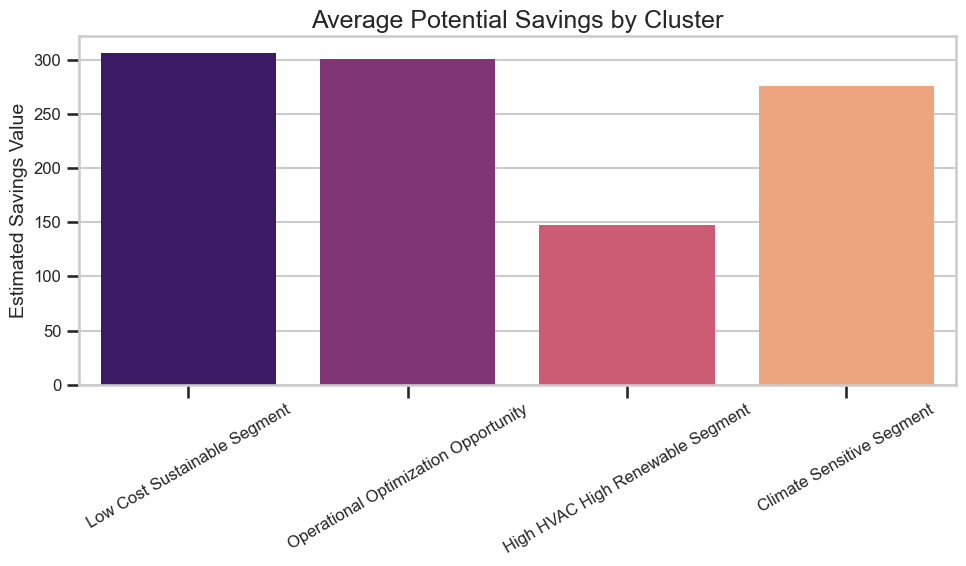

In [92]:
# ==============================
# Potential Savings Analysis
# ==============================

# Estimated potential savings per building
original_df['Potential_Savings_Value'] = (
    original_df['Savings_Gap'] *
    original_df['Energy Consumption (kWh)']
)

cluster_savings = original_df.groupby('Cluster_Name')[
    'Potential_Savings_Value'
].mean()

plt.figure(figsize=(10,6))

sns.barplot(
    data=original_df,
    x="Cluster_Name",
    y="Potential_Savings_Value",
    estimator=np.mean,
    errorbar=None,
    palette="magma"
)

plt.xticks(rotation=30)
plt.title("Average Potential Savings by Cluster")
plt.ylabel("Estimated Savings Value")
plt.xlabel("")
plt.tight_layout()
plt.show()

In [93]:
cluster_percent = (
    original_df['Cluster_Name']
    .value_counts(normalize=True) * 100
)

print(cluster_percent)

Cluster_Name
Low Cost Sustainable Segment            54.814110
High HVAC High Renewable Segment        19.391461
Climate Sensitive Segment               13.243320
Operational Optimization Opportunity    12.551108
Name: proportion, dtype: float64


In [94]:
if 'hour_sin' in original_df.columns and 'hour_cos' in original_df.columns:

    hourly_profile = original_df.groupby('Cluster')[['hour_sin', 'hour_cos']].mean()

    hourly_profile['approx_hour'] = (
        np.arctan2(hourly_profile['hour_sin'], hourly_profile['hour_cos']) 
        / (2*np.pi) * 24
    ) % 24

    print(hourly_profile[['approx_hour']])

         approx_hour
Cluster             
0          12.673940
1           1.444412
2          15.603652
3           2.539297


In [95]:
# ==============================
# Recommendation Table
# ==============================

recommendations = pd.DataFrame({
    "Cluster": [0,1,2,3],
    "Cluster_Name": [
        "Low Cost Sustainable Segment",
        "Climate Sensitive Segment",
        "Operational Optimization Opportunity",
        "High HVAC High Renewable Segment"
    ],
    "Recommended Actions": [
        "Maintain performance, predictive monitoring, minor HVAC tuning",
        "Implement climate-adaptive HVAC control & insulation upgrades",
        "Deploy occupancy-driven automation & HVAC scheduling optimization",
        "Improve HVAC efficiency & integrate demand-response systems"
    ],
    "Priority_Level": [
        "Medium",
        "High",
        "Very High",
        "Medium"
    ]
})

recommendations

,Cluster,Cluster_Name,Recommended Actions,Priority_Level
0,0,Low Cost Sustainable Segment,"Maintain performance, predictive monitoring, m...",Medium
1,1,Climate Sensitive Segment,Implement climate-adaptive HVAC control & insu...,High
2,2,Operational Optimization Opportunity,Deploy occupancy-driven automation & HVAC sche...,Very High
3,3,High HVAC High Renewable Segment,Improve HVAC efficiency & integrate demand-res...,Medium


In [96]:
# Ensure cost exists
original_df['Energy_Cost'] = (
    original_df['Energy Consumption (kWh)'] *
    original_df['Energy Price ($/kWh)']
)

cost_analysis_cluster = original_df.groupby('Cluster')['Energy_Cost'].mean()
carbon_analysis_cluster = original_df.groupby('Cluster')['Carbon_Load'].mean()
savings_analysis_cluster = original_df.groupby('Cluster')['Potential_Savings_Value'].mean()
cluster_percent = original_df['Cluster'].value_counts(normalize=True) * 100

In [97]:
final_summary = cluster_centroids.copy()

final_summary['Cluster_%'] = cluster_percent
final_summary['Avg_Energy_Cost'] = cost_analysis_cluster
final_summary['Avg_Carbon_Load'] = carbon_analysis_cluster
final_summary['Avg_Potential_Savings'] = savings_analysis_cluster

final_summary = final_summary.sort_index()

final_summary

,Energy_Intensity,HVAC_Ratio,Lighting_Ratio,Occupancy_Adjusted_Energy,Renewable_Ratio,Carbon_Load,Efficiency_Gap,Savings_Gap,Grid_Stress,Temp_Deviation,Cluster_%,Avg_Energy_Cost,Avg_Carbon_Load,Avg_Potential_Savings
Cluster,,,,,,,,,,,,,,
0,0.076372,0.280058,0.199181,0.523188,0.091279,10.119699,27.426609,4.969603,0.775286,6.833455,54.814110,9.653717,10.119699,306.441379
1,0.067524,0.244449,0.218876,0.514194,0.103933,9.968825,27.608650,4.901383,0.700904,19.601097,13.243320,8.714632,9.968825,275.833790
2,0.075931,0.290765,0.130728,0.876289,0.099633,10.035874,27.869311,4.965635,0.759375,8.444813,12.551108,9.530851,10.035874,301.006315
3,0.034097,0.711501,0.493883,0.337741,0.246117,9.145030,27.794831,5.058260,0.356272,8.184595,19.391461,4.494516,9.145030,147.058843


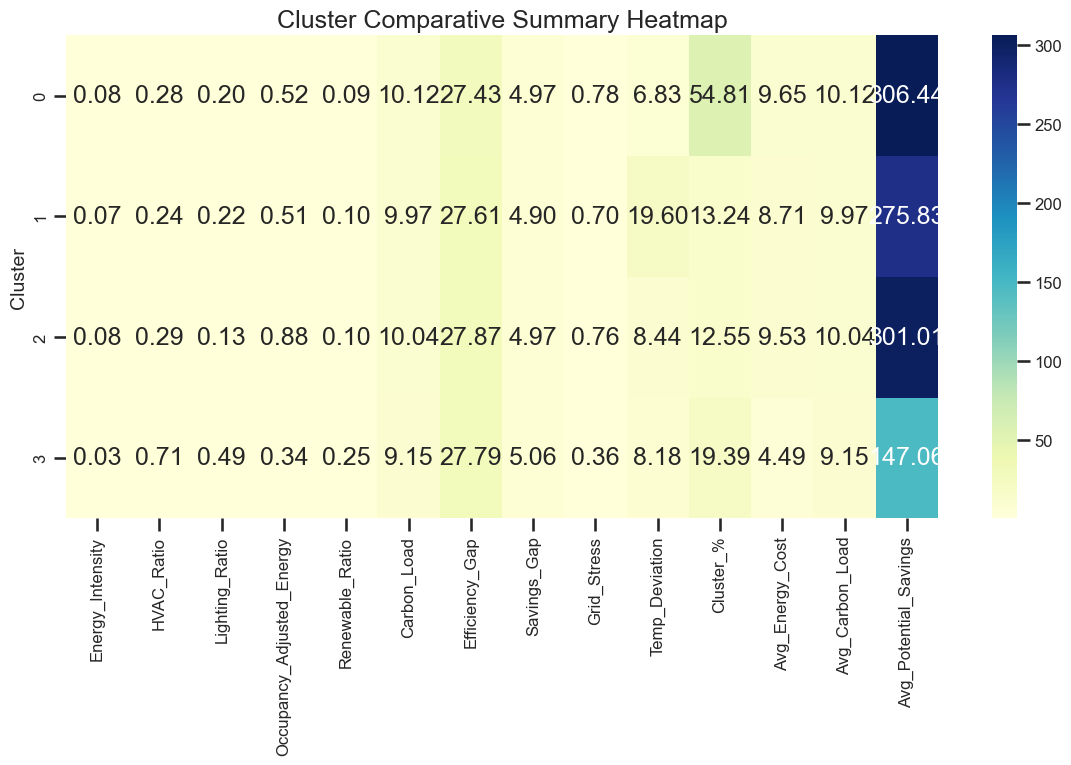

In [98]:
plt.figure(figsize=(12,8))

sns.heatmap(
    final_summary,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu"
)

plt.title("Cluster Comparative Summary Heatmap")
plt.tight_layout()
plt.show()

In [99]:
final_summary.to_csv("final_cluster_summary.csv")
recommendations.to_csv("cluster_recommendations.csv")